In [1]:
import os
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchinfo import summary
import torch_lr_finder

/home/muthu/miniconda3/envs/venv/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from model import ResNet
from trainer import Trainer
from tester import Tester
from dataloader import Cifar10DataLoader,Cifar10Dataset
from transformation import train_transforms, test_transforms
from utils import visualize_data,show_misclassified_images,plot_curves,plot_confusion_matrix,lr_curve

/home/muthu/ASUS/AIDSML/DLLessons/VISION DL/Ch10/transformation.py:5: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(
/home/muthu/ASUS/AIDSML/DLLessons/VISION DL/Ch10/transformation.py:19: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
/home/muthu/ASUS/AIDSML/DLLessons/VISION DL/Ch10/transformation.py:20: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(height=32, width=32, always_apply=True),
/home/muthu/miniconda3/envs/venv/lib/python3.12/site-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/muthu/ASUS/AIDSML/DLLessons/VISION DL/Ch10/transformation.py:30: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, f

In [3]:
DATAPATH:str = os.path.join(os.environ["HOME"],"Documents","Data")

In [4]:
# CIFAR10 Data
train_data = Cifar10Dataset(root=DATAPATH,train=True,download=False,transform=train_transforms)
test_data = Cifar10Dataset(root=DATAPATH,train=False,download=False,transform=test_transforms)

# CIFAR10 DataLoader
loader = Cifar10DataLoader(batch_size=512,is_cuda_available=True)
train_loader = loader.get_loader(train_data,train=True)
test_loader  = loader.get_loader(test_data,train=False)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Is CUDA available? ", use_cuda)


Is CUDA available?  True


In [8]:
model = ResNet(dropout_val=0.01,bias=False).to(device)
summary(model,input_data=torch.ones((1,3,32,32),device='cuda'),device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─CustomBlock: 1-2                       [1, 128, 16, 16]          --
│    └─Sequential: 2-4                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 32, 32]          73,728
│    │    └─MaxPool2d: 3-2               [1, 128, 16, 16]          --
│    │    └─BatchNorm2d: 3-3             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-4                    [1, 128, 16, 16]          --
│    └─BasicBlock: 2-5                   [1, 128, 16, 16]          --
│    │    └─Sequential: 3-5              [1, 128, 16, 16]          147,712
│

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1647425e-05..0.9608551].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08240664..1.0000732].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10583562..1.0000732].


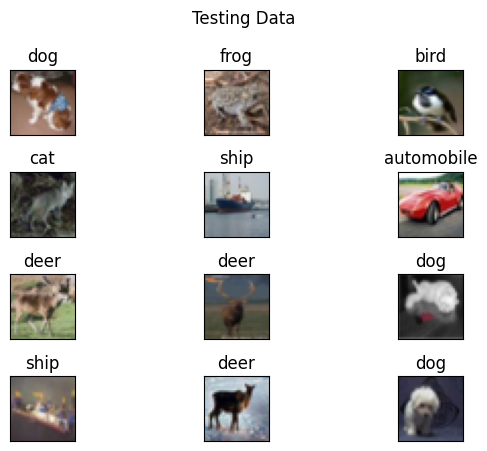

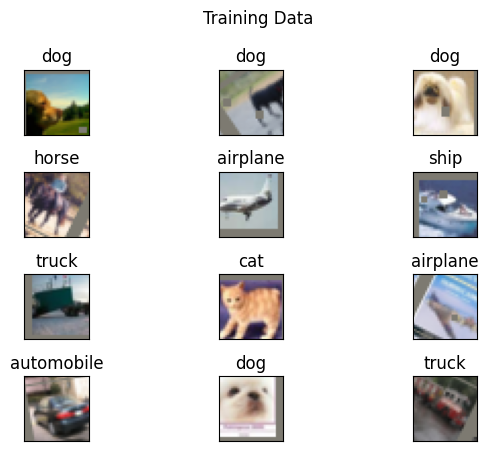

In [9]:
visualize_data(test_loader,12,"Testing Data",classes=test_data.classes);
visualize_data(train_loader,12,"Training Data",classes=train_data.classes);

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
EPOCH=24

 60%|██████    | 121/200 [00:33<00:21,  3.60it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.51E-02


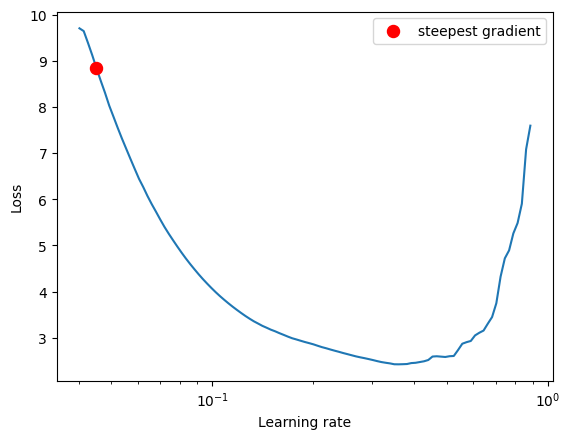

In [11]:
lr_finder = torch_lr_finder.LRFinder(model,optimizer,criterion,device=device)
lr_finder.range_test(train_loader,end_lr=10,num_iter=200,step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [12]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=6.04E-02, 
                                          pct_start=3/EPOCH,  #5/EPOCH
                                          anneal_strategy='linear',
                                        #   cycle_momentum=True,
                                        #   base_momentum=0.85,
                                        #   max_momentum=0.98,
                                          steps_per_epoch=len(train_loader),
                                          epochs= EPOCH,
                                          three_phase=False,
                                          div_factor=100,
                                          final_div_factor=100
            )



trainer = Trainer(model, train_loader, optimizer, criterion,scheduler, device)
tester = Tester(model, test_loader, criterion, device)


target_acc = 90
for epoch in range(0, EPOCH):
    trainer.train(epoch=epoch)
    test_acc,test_loss = tester.test()
    if test_acc>target_acc:
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'scheduler':scheduler.state_dict(),
            'epoch':epoch
        },f"./data/best_model_{test_acc}.pth")
        target_acc = test_acc

    print('-'*150)

EPOCH=0| LR=0.020604027303754265| LOSS=1.63| BATCH=97| ACCURACY=37.410: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s] 
LOSS=34.80| BATCH=19| ACCURACY=42.600: 100%|██████████| 20/20 [00:01<00:00, 14.90it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=1| LR=0.04060405460750853| LOSS=1.21| BATCH=97| ACCURACY=49.510: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s] 
LOSS=26.80| BATCH=19| ACCURACY=55.500: 100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=2| LR=0.060370654052478136| LOSS=1.31| BATCH=97| ACCURACY=59.584: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]
LOSS=21.99| BATCH=19| ACCURACY=63.240: 100%|██████████| 20/20 [00:01<00:00, 15.27it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=3| LR=0.05749475119533528| LOSS=1.07| BATCH=97| ACCURACY=64.868: 100%|██████████| 98/98 [00:18<00:00,  5.25it/s] 
LOSS=23.93| BATCH=19| ACCURACY=58.740: 100%|██████████| 20/20 [00:01<00:00, 16.21it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=4| LR=0.05461884833819242| LOSS=1.04| BATCH=97| ACCURACY=67.304: 100%|██████████| 98/98 [00:18<00:00,  5.23it/s] 
LOSS=29.95| BATCH=19| ACCURACY=54.370: 100%|██████████| 20/20 [00:01<00:00, 15.25it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=5| LR=0.05174294548104956| LOSS=0.92| BATCH=97| ACCURACY=68.696: 100%|██████████| 98/98 [00:18<00:00,  5.27it/s] 
LOSS=22.01| BATCH=19| ACCURACY=64.880: 100%|██████████| 20/20 [00:01<00:00, 15.09it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=6| LR=0.048867042623906704| LOSS=0.88| BATCH=97| ACCURACY=69.150: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]
LOSS=22.24| BATCH=19| ACCURACY=62.660: 100%|██████████| 20/20 [00:01<00:00, 15.96it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=7| LR=0.04599113976676385| LOSS=0.85| BATCH=97| ACCURACY=70.154: 100%|██████████| 98/98 [00:18<00:00,  5.21it/s] 
LOSS=16.42| BATCH=19| ACCURACY=71.570: 100%|██████████| 20/20 [00:01<00:00, 15.90it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=8| LR=0.04311523690962099| LOSS=0.93| BATCH=97| ACCURACY=70.810: 100%|██████████| 98/98 [00:18<00:00,  5.30it/s] 
LOSS=16.57| BATCH=19| ACCURACY=71.030: 100%|██████████| 20/20 [00:01<00:00, 16.16it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=9| LR=0.040239334052478135| LOSS=0.80| BATCH=97| ACCURACY=71.154: 100%|██████████| 98/98 [00:18<00:00,  5.22it/s]
LOSS=17.82| BATCH=19| ACCURACY=71.510: 100%|██████████| 20/20 [00:01<00:00, 15.70it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=10| LR=0.03736343119533528| LOSS=0.88| BATCH=97| ACCURACY=71.460: 100%|██████████| 98/98 [00:18<00:00,  5.20it/s] 
LOSS=23.64| BATCH=19| ACCURACY=63.190: 100%|██████████| 20/20 [00:01<00:00, 15.11it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=11| LR=0.03448752833819242| LOSS=0.81| BATCH=97| ACCURACY=72.178: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s] 
LOSS=16.62| BATCH=19| ACCURACY=71.120: 100%|██████████| 20/20 [00:01<00:00, 15.09it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=12| LR=0.031611625481049566| LOSS=0.82| BATCH=97| ACCURACY=72.866: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]
LOSS=14.33| BATCH=19| ACCURACY=75.740: 100%|██████████| 20/20 [00:01<00:00, 15.06it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=13| LR=0.028735722623906702| LOSS=0.89| BATCH=97| ACCURACY=73.642: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]
LOSS=18.96| BATCH=19| ACCURACY=70.790: 100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=14| LR=0.025859819766763853| LOSS=0.67| BATCH=97| ACCURACY=74.332: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]
LOSS=14.32| BATCH=19| ACCURACY=75.200: 100%|██████████| 20/20 [00:01<00:00, 15.04it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=15| LR=0.02298391690962099| LOSS=0.73| BATCH=97| ACCURACY=75.050: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s] 
LOSS=14.94| BATCH=19| ACCURACY=75.560: 100%|██████████| 20/20 [00:01<00:00, 15.08it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=16| LR=0.020108014052478133| LOSS=0.73| BATCH=97| ACCURACY=76.012: 100%|██████████| 98/98 [00:18<00:00,  5.20it/s]
LOSS=13.16| BATCH=19| ACCURACY=76.880: 100%|██████████| 20/20 [00:01<00:00, 15.95it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=17| LR=0.017232111195335277| LOSS=0.64| BATCH=97| ACCURACY=77.056: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]
LOSS=11.62| BATCH=19| ACCURACY=80.840: 100%|██████████| 20/20 [00:01<00:00, 15.13it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=18| LR=0.01435620833819242| LOSS=0.65| BATCH=97| ACCURACY=77.924: 100%|██████████| 98/98 [00:19<00:00,  5.14it/s] 
LOSS=11.54| BATCH=19| ACCURACY=81.380: 100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=19| LR=0.011480305481049558| LOSS=0.62| BATCH=97| ACCURACY=79.088: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]
LOSS=11.54| BATCH=19| ACCURACY=81.030: 100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=20| LR=0.008604402623906708| LOSS=0.58| BATCH=97| ACCURACY=80.634: 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]
LOSS=9.86| BATCH=19| ACCURACY=83.500: 100%|██████████| 20/20 [00:01<00:00, 16.15it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=21| LR=0.005728499766763845| LOSS=0.51| BATCH=97| ACCURACY=82.402: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s] 
LOSS=8.53| BATCH=19| ACCURACY=85.400: 100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=22| LR=0.0028525969096209955| LOSS=0.43| BATCH=97| ACCURACY=84.252: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]
LOSS=7.18| BATCH=19| ACCURACY=87.620: 100%|██████████| 20/20 [00:01<00:00, 15.07it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=23| LR=-2.3305947521867765e-05| LOSS=0.41| BATCH=97| ACCURACY=86.376: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]
LOSS=6.60| BATCH=19| ACCURACY=89.120: 100%|██████████| 20/20 [00:01<00:00, 14.85it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------


In [13]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

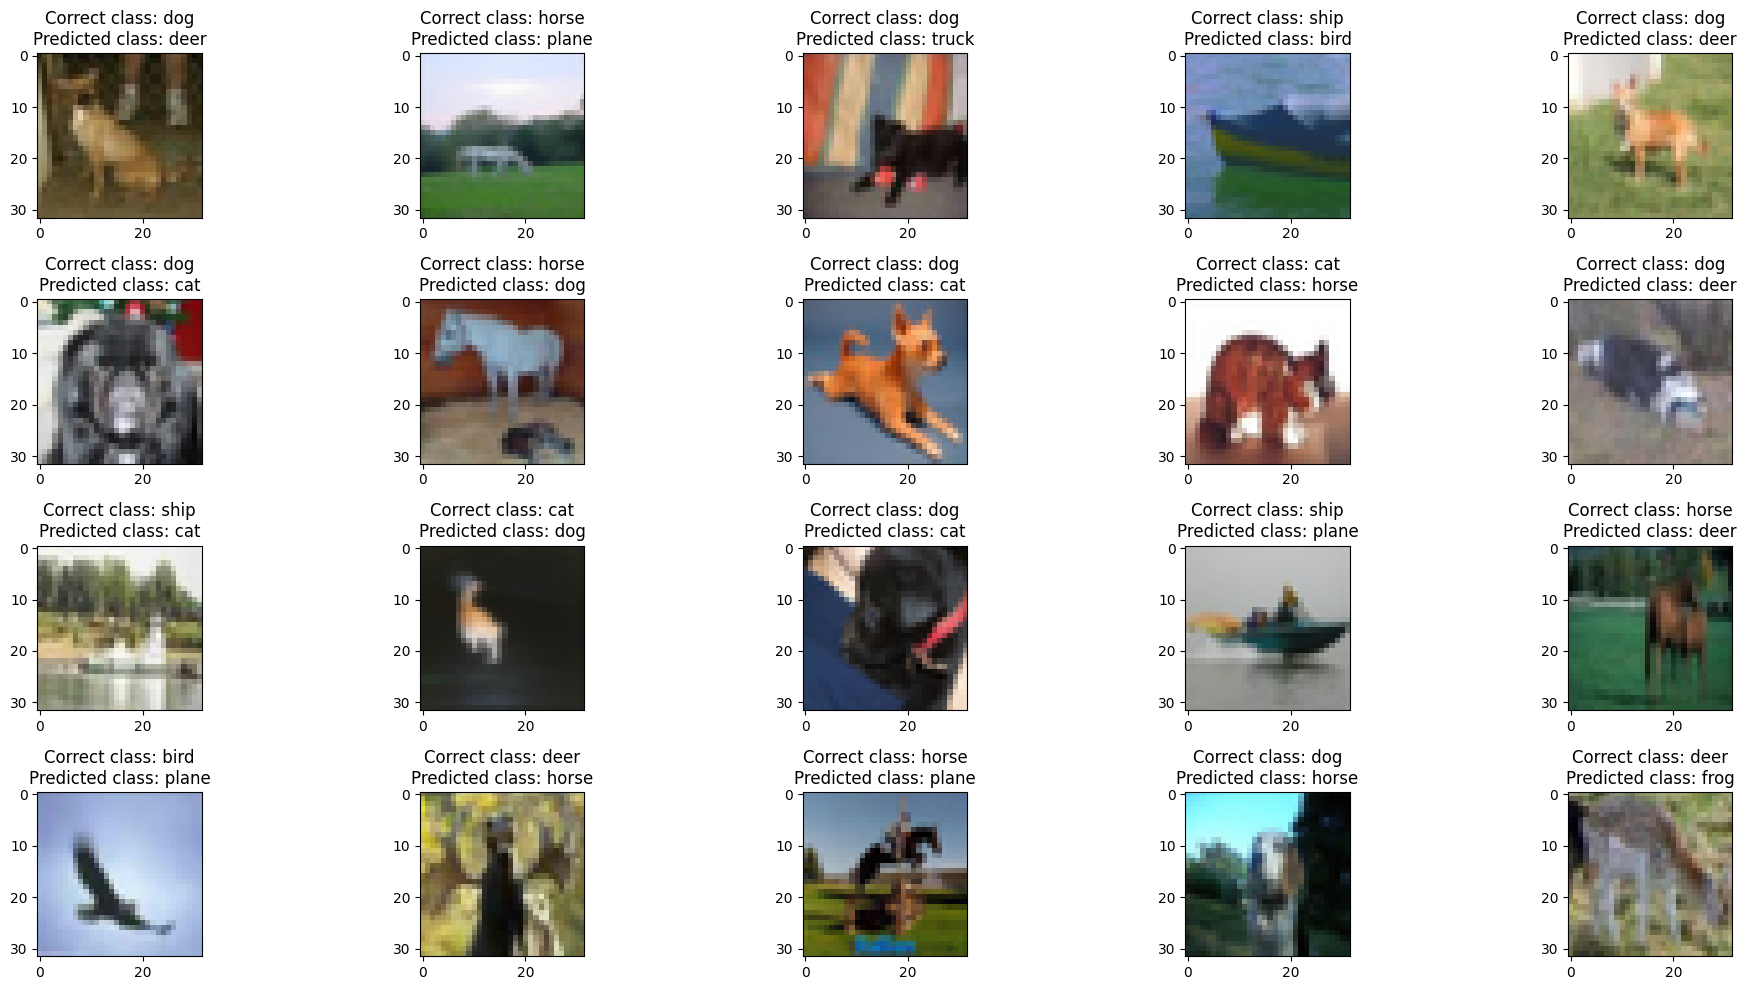

In [14]:
show_misclassified_images(
    misclassified_images[:20],
    predictions[:20],
    labels[:20],
    [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ],
);


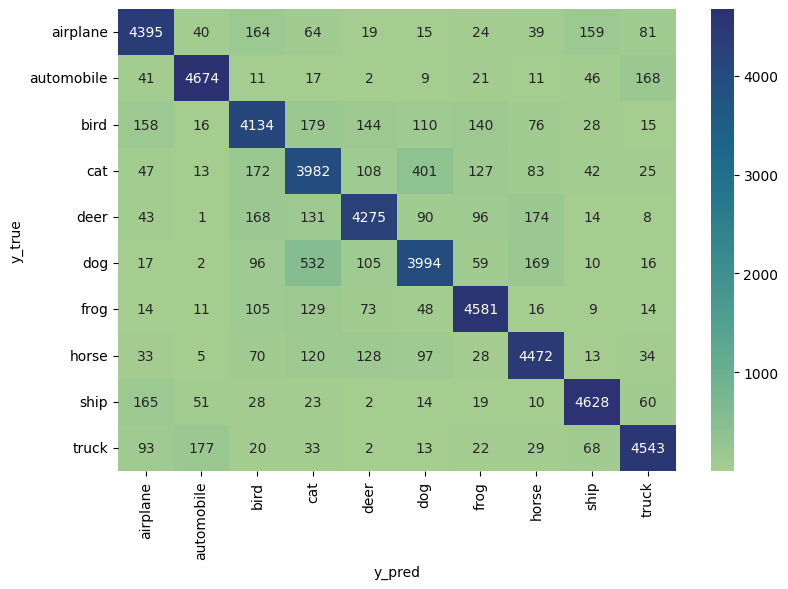

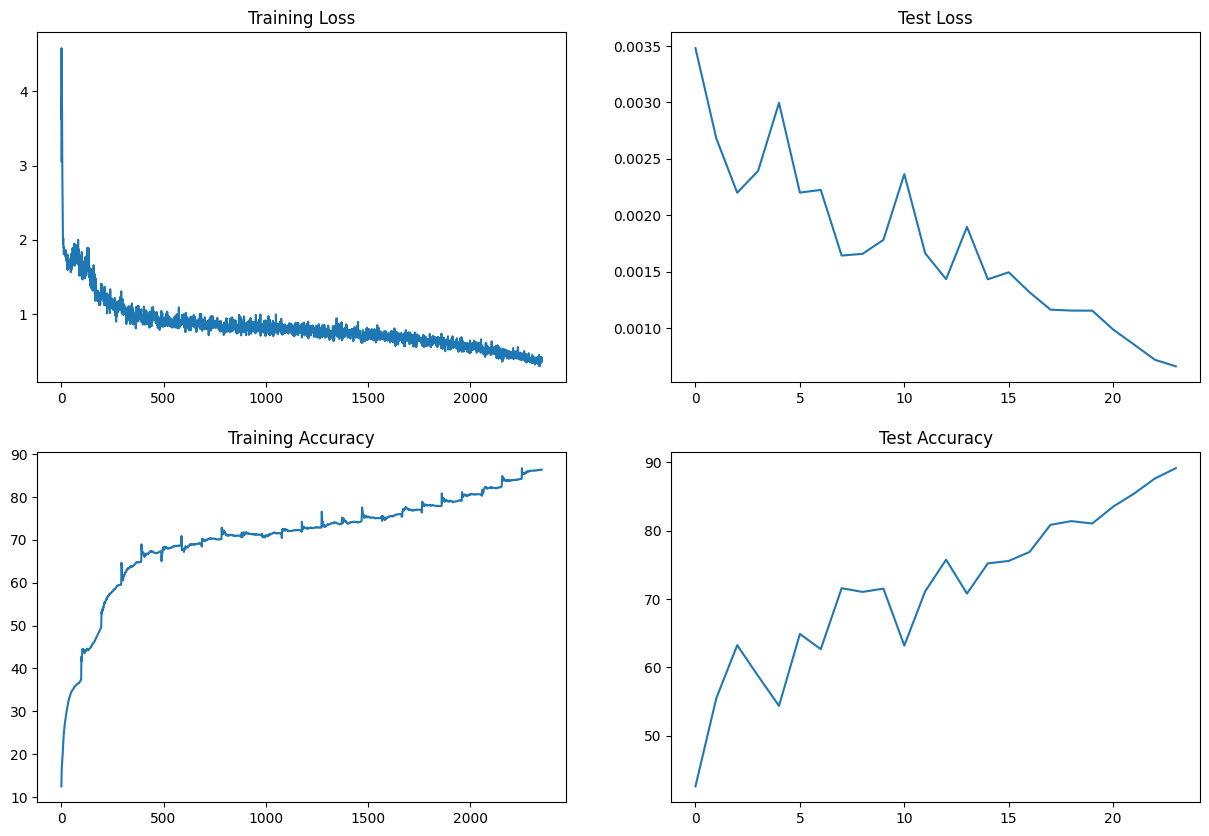

In [15]:
plot_confusion_matrix(model,train_loader,'cuda',train_loader.dataset.classes);
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies);

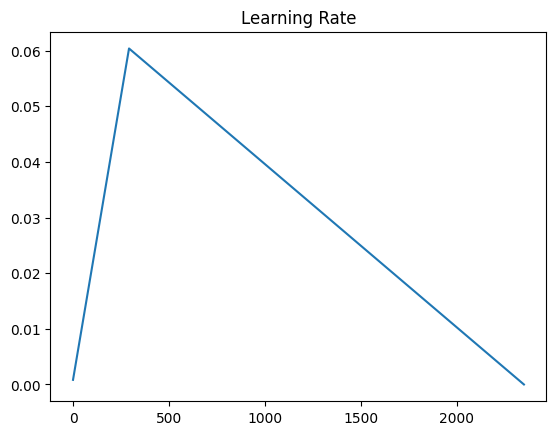

In [16]:
lr_curve(trainer.lr_history)